# Rocket equation 1D

To derive, start with

$$  \frac{dp}{dt} = \sum_i F_i $$

Let 

* $v(t)$ be the speed of the rocket
* $m(t)$ be the mass of the rocket 
* $v_g$ be the speed the rocket expels fuel
* $b$ be the coefficient of friction

# LHS

* **The Rocket**

$p=m(t)v(t) \implies dp = vdm + mdv$

* **The fuel coming out of the rocket**: (Note the $dm$ negative since rocket is losing mass)

$dp = -dm(v-v_g)$

* **Total**

$$dp = vdm + mdv -dm(v-v_g) = mdv + v_g dm \implies \boxed{\frac{dp}{dt} = m\frac{dv}{dt} + v_g \frac{dm}{dt}}$$

# RHS

Friction and gravity $\boxed{\sum F = -m(t) g -bv^2}$ (assuming rocket moving upwards)

# Setting LHS = RHS

After a bit of simple algebra

$$ \frac{dv}{dt} = -g -\frac{b}{m(t)}v^2 - \frac{v_g}{m(t)}\frac{dm(t)}{dt} $$

Dividing by fuel explusion speed $v_g$ and multiplying by some characteristic launch time $T_0$ yields

$$ \frac{dv'}{dt'} = -\frac{g T_0}{v_g} -\frac{b v_g T_0}{m(t)}v'^2 - \frac{1}{m(t)}\frac{dm(t)}{dt'} $$

where $\boxed{v'=v/v_g}$ and $\boxed{t'=t/T_0}$. Now let $\boxed{m(t) = m_0 z(t)}$ where $m_0$ is the initial mass of the rocket. If the rocket decreases to 1/10th its mass after $T_0$ it follows that $z(t'=0)=1$ and $z(t'=1) = 1/10$. Substituting this in...

$$ \frac{dv'}{dt'} = -\frac{g T_0}{v_g} -\frac{b v_g T_0}{m_0 z(t')}v'^2 - \frac{1}{z(t')}\frac{dz(t')}{dt'} $$

Now letting $\boxed{m_0' = m_0/bv_g T_0}$ we get

$$ \boxed{\frac{dv'}{dt'} = -\frac{g T_0}{v_g} -\frac{1}{m_0' z(t')}v'^2 - \frac{1}{z(t')}\frac{dz(t')}{dt'}} $$


This equation is easier since we only need to specify

* $m_0'$ contains all the information about the rocket mass, the friction force, and the rate at which fuel is expelled
* $z(t')$, the function that quantifies how fast the mass of the fuel is depleted. Here we will use $z(t') = 1-\frac{9}{10}t'^n$ so that $n$ specifies how fuel is disposed
* $v_g$, the speed at which fuel is expelled

Question: For a given $m_0'$ and $v_g$, what function $z(t')$ gets the rocket upwards to a point $h_0$ in the fastest time?

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import sympy as smp
from scipy.integrate import solve_ivp
plt.style.use(['science','notebook'])

Setting all our constants

In [3]:
#set params
T0 = 40
g=9.81
vg=500
M0=2e4
b=0.1
m0=M0/(b*vg*T0)

Use sympy to define fuel loss function $z(t)$ and get derivative $dz/dt$. Then convert these into numerical python functions

In [10]:
t, n =smp.symbols('t,n')
z= 1-(9/10)*t**n
dzdt=smp.diff(z,t).simplify()
#numerical functions
z= smp.lambdify([t,n],z)
dzdt =smp.lambdify([t,n],dzdt)

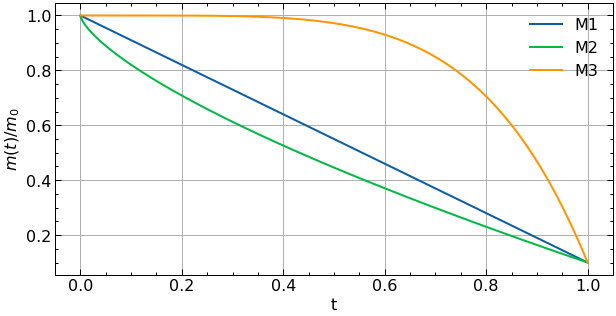

In [12]:
#diff ways to expel fuel
t=np.linspace(1e-4,1,10000)
z1= z(t,1)
z2= z(t,0.7)
z3= z(t,5)
plt.figure(figsize=(10,5))
plt.plot(t,z1, label='M1')
plt.plot(t,z2, label='M2')
plt.plot(t,z3, label='M3')
plt.ylabel('$m(t)/m_0$')
plt.xlabel('t')
plt.grid()
plt.legend()

Define our ODE system $\vec{S} = (x, v)$ and $d\vec{S}/dt = (dx/dt, dv/dt)$

In [17]:
def dSdt(t,S,m0,vg,n,T=40):
    x, v = S[0], S[1]
    if t<1: #still have fuel left in the tank
        dxdt = v
        dvdt = -g*T0/vg -1/(m0*z(t,n))*v**2 * np.sign(v) - 1/z(t,n) * dzdt(t,n)
    else:   #out of fuel
        dxdt = v
        dvdt = -g*T0/vg -1/(m0*z(t,n))*v**2 * np.sign(v)
    if(dvdt<0)*(dxdt<0)*(x<=0): #dont wanna PENETRATE the ground
        dxdt = 0
        dvdt = 0
    return [dxdt,dvdt]

Solve for a few different ways to expell fuel and plot

In [19]:
n1 , n2, n3 = 1, 0.7, 5.05
sol1=solve_ivp(dSdt, [1e-4,3], y0=[0,0], t_eval= np.linspace(1e-4,3,10000), args=(m0,vg,n1,T0))
sol2=solve_ivp(dSdt, [1e-4,3], y0=[0,0], t_eval= np.linspace(1e-4,3,10000), args=(m0,vg,n2,T0))
sol3=solve_ivp(dSdt, [1e-4,3], y0=[0,0], t_eval= np.linspace(1e-4,3,10000), args=(m0,vg,n3,T0))

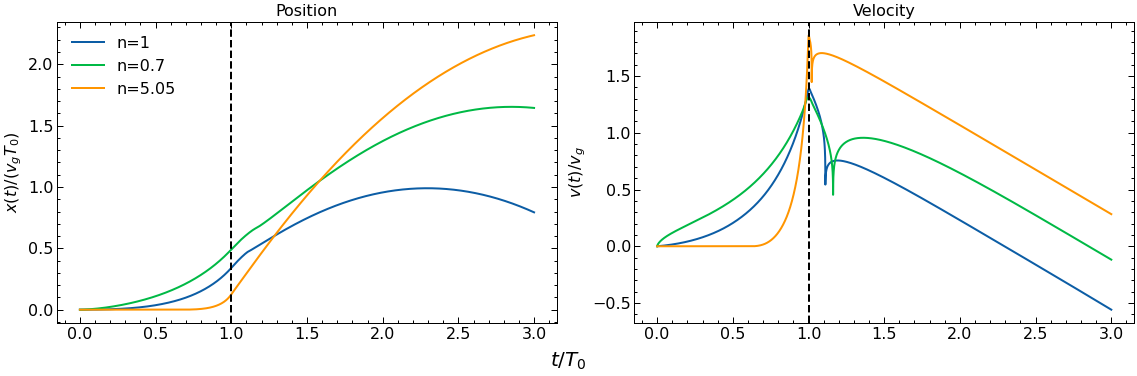

In [23]:
fig, axes = plt.subplots(1, 2, figsize=(16,5))
ax = axes[0]
ax.plot(sol1.t, sol1.y[0], label='n={}'.format(n1))
ax.plot(sol2.t, sol2.y[0], label='n={}'.format(n2))
ax.plot(sol3.t, sol3.y[0], label='n={}'.format(n3))
ax.axvline(1, ls='--', color='k')
ax.set_ylabel('$x(t)/(v_g T_0)$')
ax.set_title('Position')
ax.legend()
plt.grid()
ax = axes[1]
ax.plot(sol1.t, sol1.y[1], label='n=1')
ax.plot(sol2.t, sol2.y[1], label='n=0.7')
ax.plot(sol3.t, sol3.y[1], label='n=1.3')
ax.axvline(1, ls='--', color='k')
ax.set_ylabel('$v(t)/v_g$')
ax.set_title('Velocity')
fig.text(0.5, -0.04, '$t/T_0$', ha='center', fontsize=20)
fig.tight_layout()
plt.grid()